In [3]:
from pyspark.sql import SparkSession, functions as f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
spark = (
    SparkSession.builder.appName("Preprocessing_Yellow")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '3g')   
    .config('spark.executor.memory', '4g')  
    .config('spark.executor.instances', '2')  
    .config('spark.executor.cores', '2')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/10/05 21:38:34 WARN Utils: Your hostname, DulanComputer resolves to a loopback address: 127.0.1.1; using 172.30.15.25 instead (on interface eth0)
23/10/05 21:38:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/05 21:38:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
joined = spark.read.parquet("../../../data/curated/removed_outliers.parquet")

In [6]:
joined.show()

23/10/05 21:39:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+--------------------+-------------+------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+--------------------------------+---------------------------+------------------+------------------+--------------------+---------------------------------+--------------------+------------------+
|merchant_abn|                name|revenue_level|         take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|number_of_orders|average_cost_of_order|average_spend_per_consumer|a

In [7]:
joined.select("average_cost_of_order").describe()

summary,average_cost_of_order
count,3965
mean,966.2920798744659
stddev,2205.253354979304
min,7.5790717564896335
max,28754.635212595258


In [6]:
joined.select("number_of_unique_consumers").describe()

summary,number_of_unique_consumers
count,3965
mean,1717.6534678436317
stddev,3254.9274012569444
min,4
max,20115


In [7]:
joined.select("number_of_repeat_consumers").describe()

summary,number_of_repeat_consumers
count,3965
mean,468.66027742749054
stddev,1937.7782868661402
min,0
max,20113


In [8]:
joined.select("number_of_postcodes").describe()

summary,number_of_postcodes
count,3965
mean,739.2691046658259
stddev,838.1174200278368
min,3
max,2639


Pie Chart for number of merchants within a segment

In [13]:
segments = joined.groupBy("segment").agg(f.count("merchant_abn").alias("num_merchants"))
segments = segments.toPandas()

In [14]:
segments["segment"]

0    garden_and_furnishings
1    antiques_and_jewellery
2      specialized_services
3      tech_and_electronics
4        retail_and_novelty
Name: segment, dtype: object

In [17]:
segments_lst = ["Garden and Furniture", "Antiques and Jewellery", "Specialized Services",
                "Tech and Electronics", "Retail and Novelty"]
merchant_num_lst = list(segments["num_merchants"])

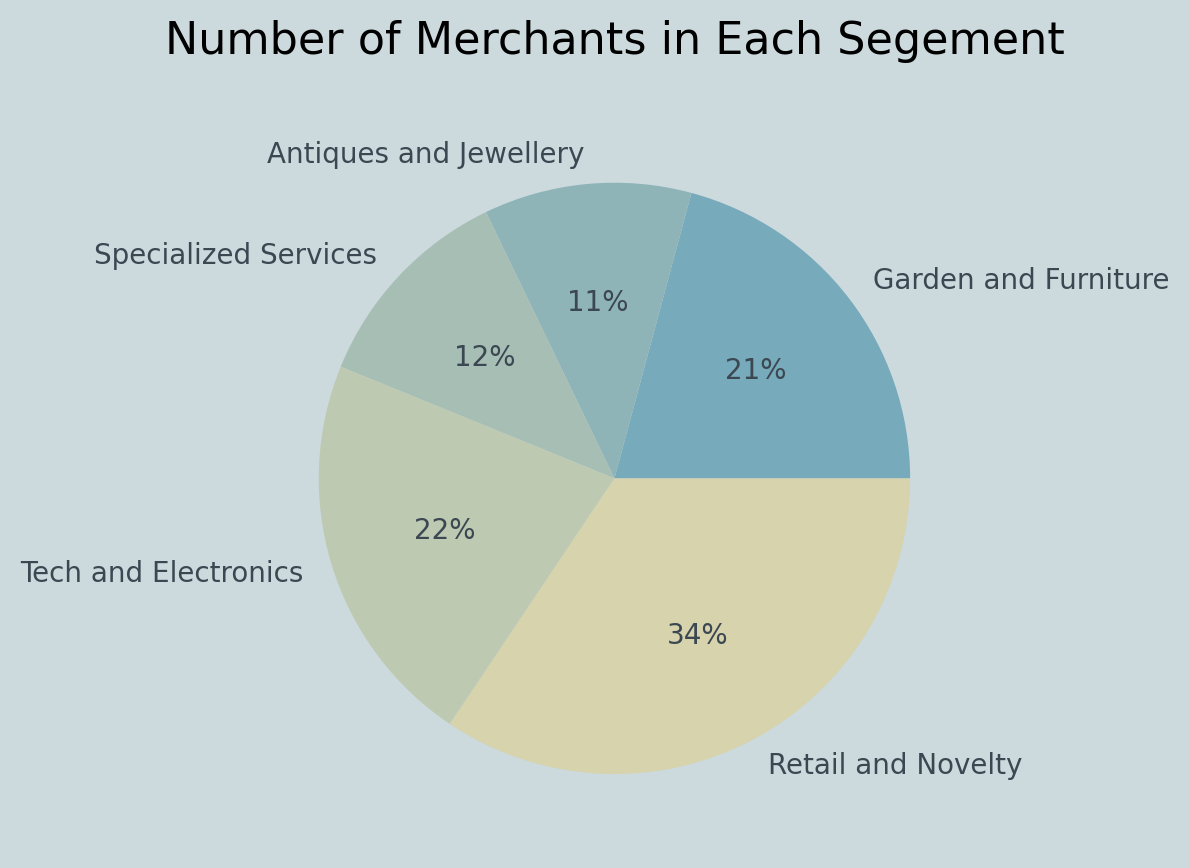

In [58]:
plt.figure(facecolor= "#ccdadd")
color_palette = sns.color_palette("blend:#7AB,#EDA")
plt.pie(merchant_num_lst, labels = segments_lst, colors=color_palette, autopct="%.0f%%",
        textprops={'color': "#3b4852"})
plt.title("Number of Merchants in Each Segement", pad = 20, fontsize = 16)
plt.savefig("../../../plots/segementspieplot.png", bbox_inches='tight')
plt.show()

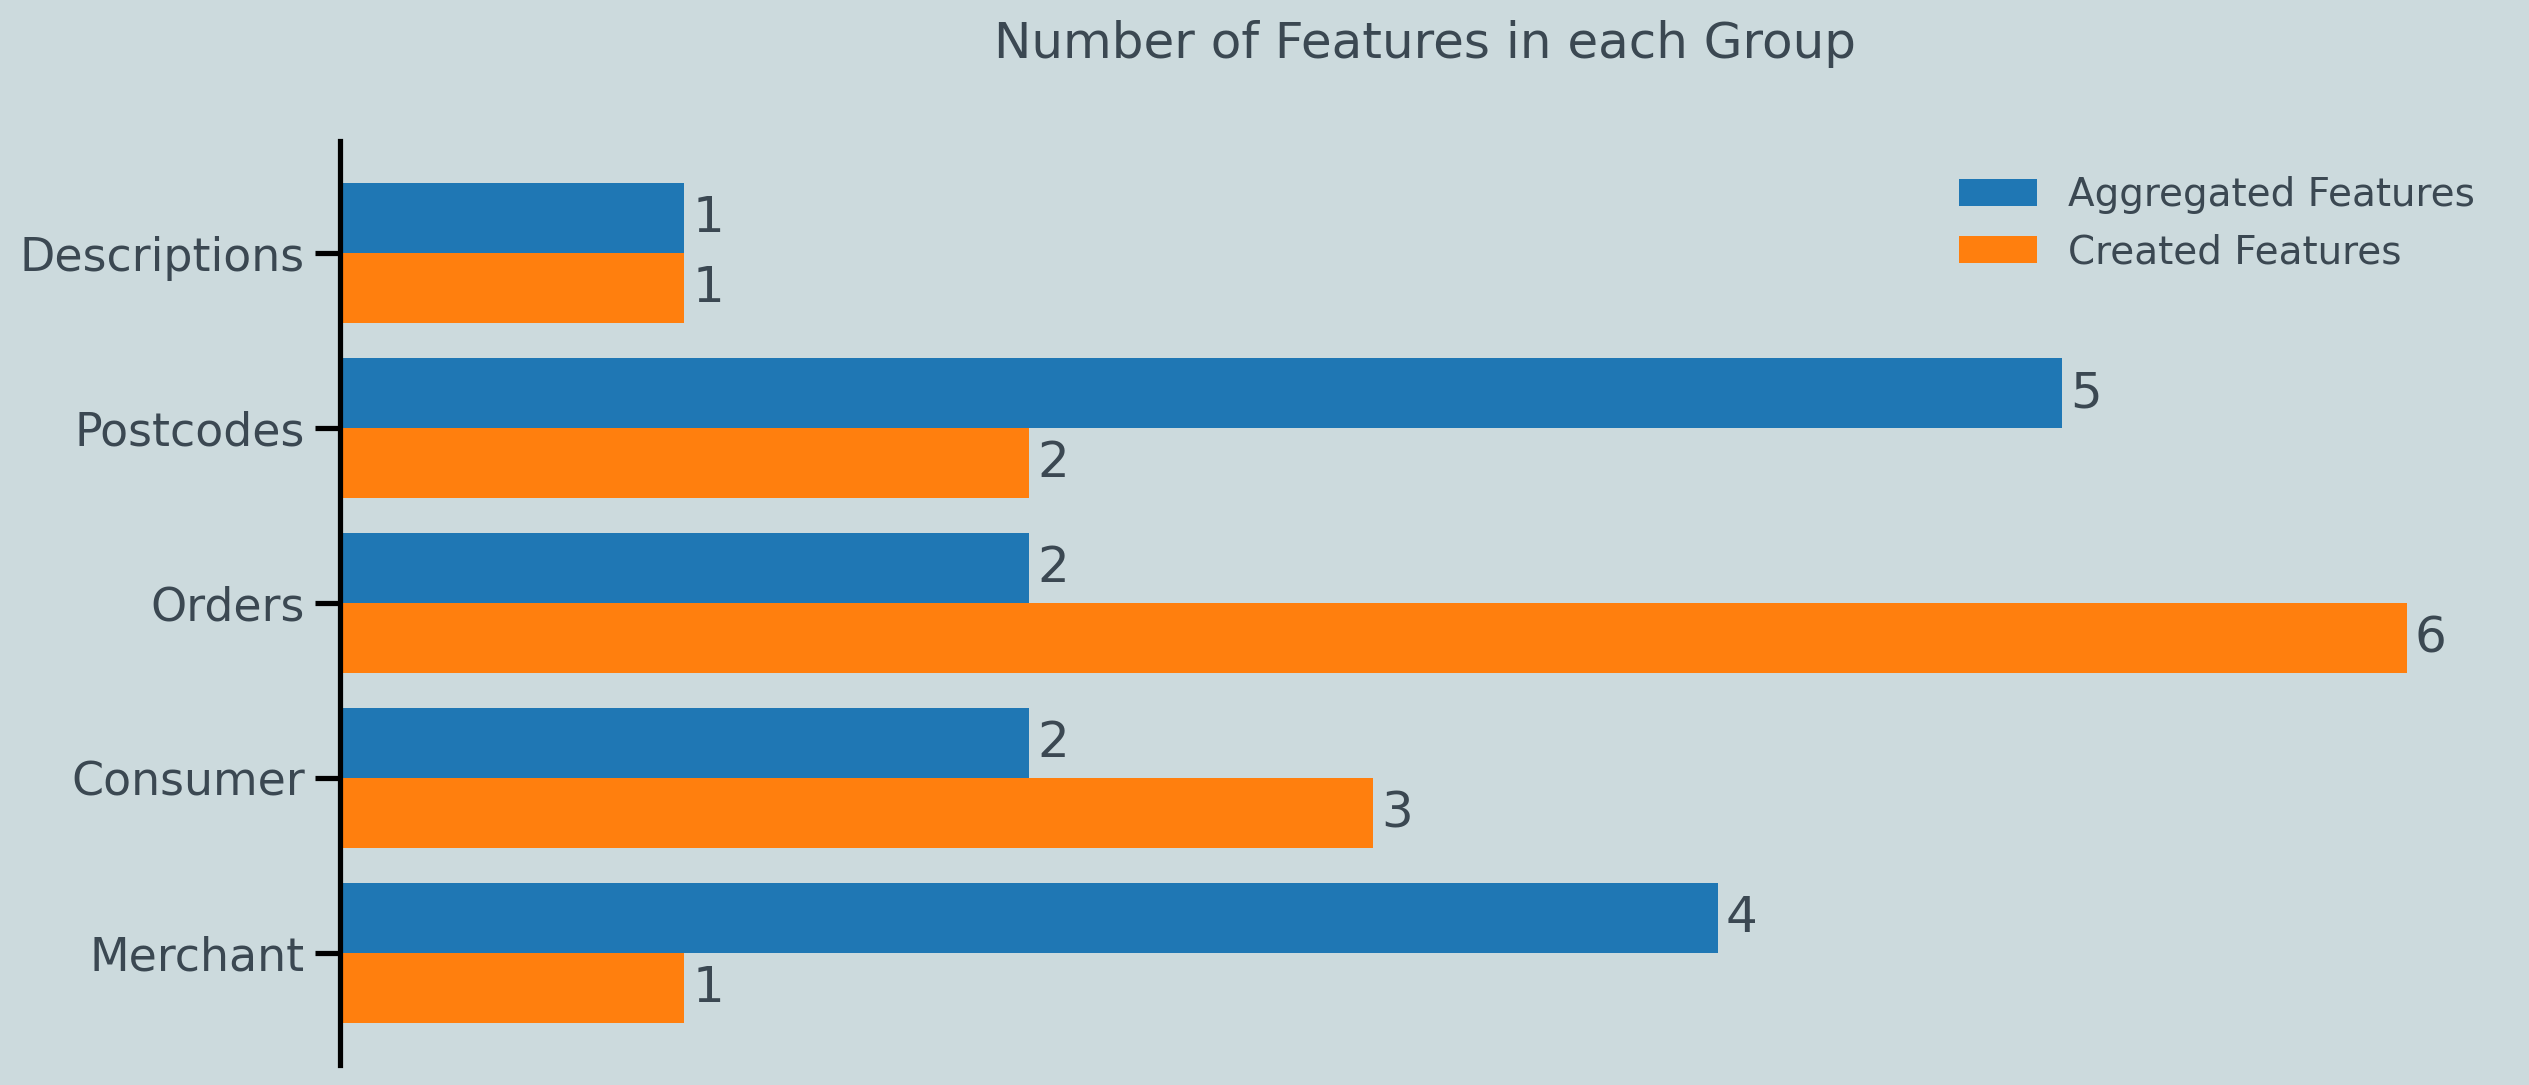

In [117]:
feature_groups = ["Merchant", "Consumer", "Orders", "Postcodes", "Descriptions"]
num_aggregated = [4,2,2,5,1]
num_engineered = [1,3,6,2,1]

X_axis = np.arange(len(feature_groups)) 

sns.set_context('talk')

fig, ax = plt.subplots(figsize=(14, 6))
fig.set_facecolor("#ccdadd")
ax.set_facecolor("#ccdadd")

bar1 = ax.barh(X_axis + 0.2, num_aggregated, 0.4, label='Aggregated Features')
bar2 = ax.barh(X_axis - 0.2, num_engineered, 0.4, label='Created Features')

# Add bar labels
for bar in bar1 + bar2:
    width = bar.get_width()
    ax.annotate('{}'.format(width),
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(3, 0),  # 3 points horizontal offset
                 textcoords="offset points",
                 ha='left', va='center',
                 color = "#3b4852",)

ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.xaxis.set_visible(False)

ax.set_yticks(X_axis, feature_groups, color = "#3b4852") 
ax.set_title("Number of Features in each Group", pad=30, loc = "center", color = "#3b4852") 
ax.legend(fontsize=14, loc='upper right', frameon=False, labelcolor="#3b4852") 

plt.savefig("../../../plots/Num_features_bar.png")
plt.show() 